In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import torch
import numpy as np
from matplotlib import pyplot as plt
from data import PVDataGenerator, PVDataLoader
from data.utils import cross_val_fold, train_test_split_fold
from hypertuning import BetaQPGPOneDim

In [2]:
# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 365
N_DAYS_TRAIN = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 2
RADIUS = 0.35
CIRCLE_COORDS = (55, -1.5)
# create a tuple of 4 coordinates that form a polygon in the uk

POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [3]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=POLY_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='poly',
                    drop_nan=False)

X, y = generator.get_time_series()

==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [4]:
x_list, y_list = cross_val_fold(X, y, N_DAYS_TRAIN, DAILY_DATA_POINTS)
x_train, y_train, x_test, y_test =  train_test_split_fold(x_list, y_list, N_HOURS_PRED, MINUTE_INTERVAL, DAY_MIN, DAY_MAX)

In [5]:
train_loader = PVDataLoader(x_train, y_train)
test_loader = PVDataLoader(x_test, y_test)

In [6]:
x_tr_winter, y_tr_winter, x_te_winter, y_te_winter = [],[],[],[]
x_tr_spring, y_tr_spring, x_te_spring, y_te_spring = [],[],[],[]
x_tr_summer, y_tr_summer, x_te_summer, y_te_summer = [],[],[],[]
x_tr_fall, y_tr_fall, x_te_fall, y_te_fall = [],[],[],[]

# use the lists that has 73 elements with five days of in consecutive order to fill in the lists
# winter is the first 365/(5*4) = 18, spring is the next 18, summer, fall, etc.

for i, ((x_tr, y_tr), (x_te, y_te)) in enumerate(zip(train_loader, test_loader)):

    idx = np.random.randint(0, y_tr.size(-1), 2)
    # winter indices
    if i < 12 or i > 75 - 4:

        x_tr_winter.append(x_tr)
        y_tr_winter.append(y_tr[:,idx])
        x_te_winter.append(x_te)
        y_te_winter.append(y_te[:,idx])
    
    # spring indices
    elif i < 20:
        x_tr_spring.append(x_tr)
        y_tr_spring.append(y_tr[:,idx])
        x_te_spring.append(x_te)
        y_te_spring.append(y_te[:,idx])
    
    elif i < 48:
        x_tr_summer.append(x_tr)
        y_tr_summer.append(y_tr[:,idx])
        x_te_summer.append(x_te)
        y_te_summer.append(y_te[:,idx])
    
    elif i < 66:
        x_tr_fall.append(x_tr)
        y_tr_fall.append(y_tr[:,idx])
        x_te_fall.append(x_te)
        y_te_fall.append(y_te[:,idx])
    
    else:
        # winter indices
        x_tr_winter.append(x_tr)
        y_tr_winter.append(y_tr[:,idx])
        x_te_winter.append(x_te)
        y_te_winter.append(y_te[:,idx])

In [7]:
train_loader_w = PVDataLoader(x_tr_winter, y_tr_winter)
test_loader_w = PVDataLoader(x_te_winter, y_te_winter)

train_loader_sp = PVDataLoader(x_tr_spring, y_tr_spring)
test_loader_sp = PVDataLoader(x_te_spring, y_te_spring)

train_loader_su = PVDataLoader(x_tr_summer, y_tr_summer)
test_loader_su = PVDataLoader(x_te_summer, y_te_summer)

train_loader_f = PVDataLoader(x_tr_fall, y_tr_fall)
test_loader_f = PVDataLoader(x_te_fall, y_te_fall)


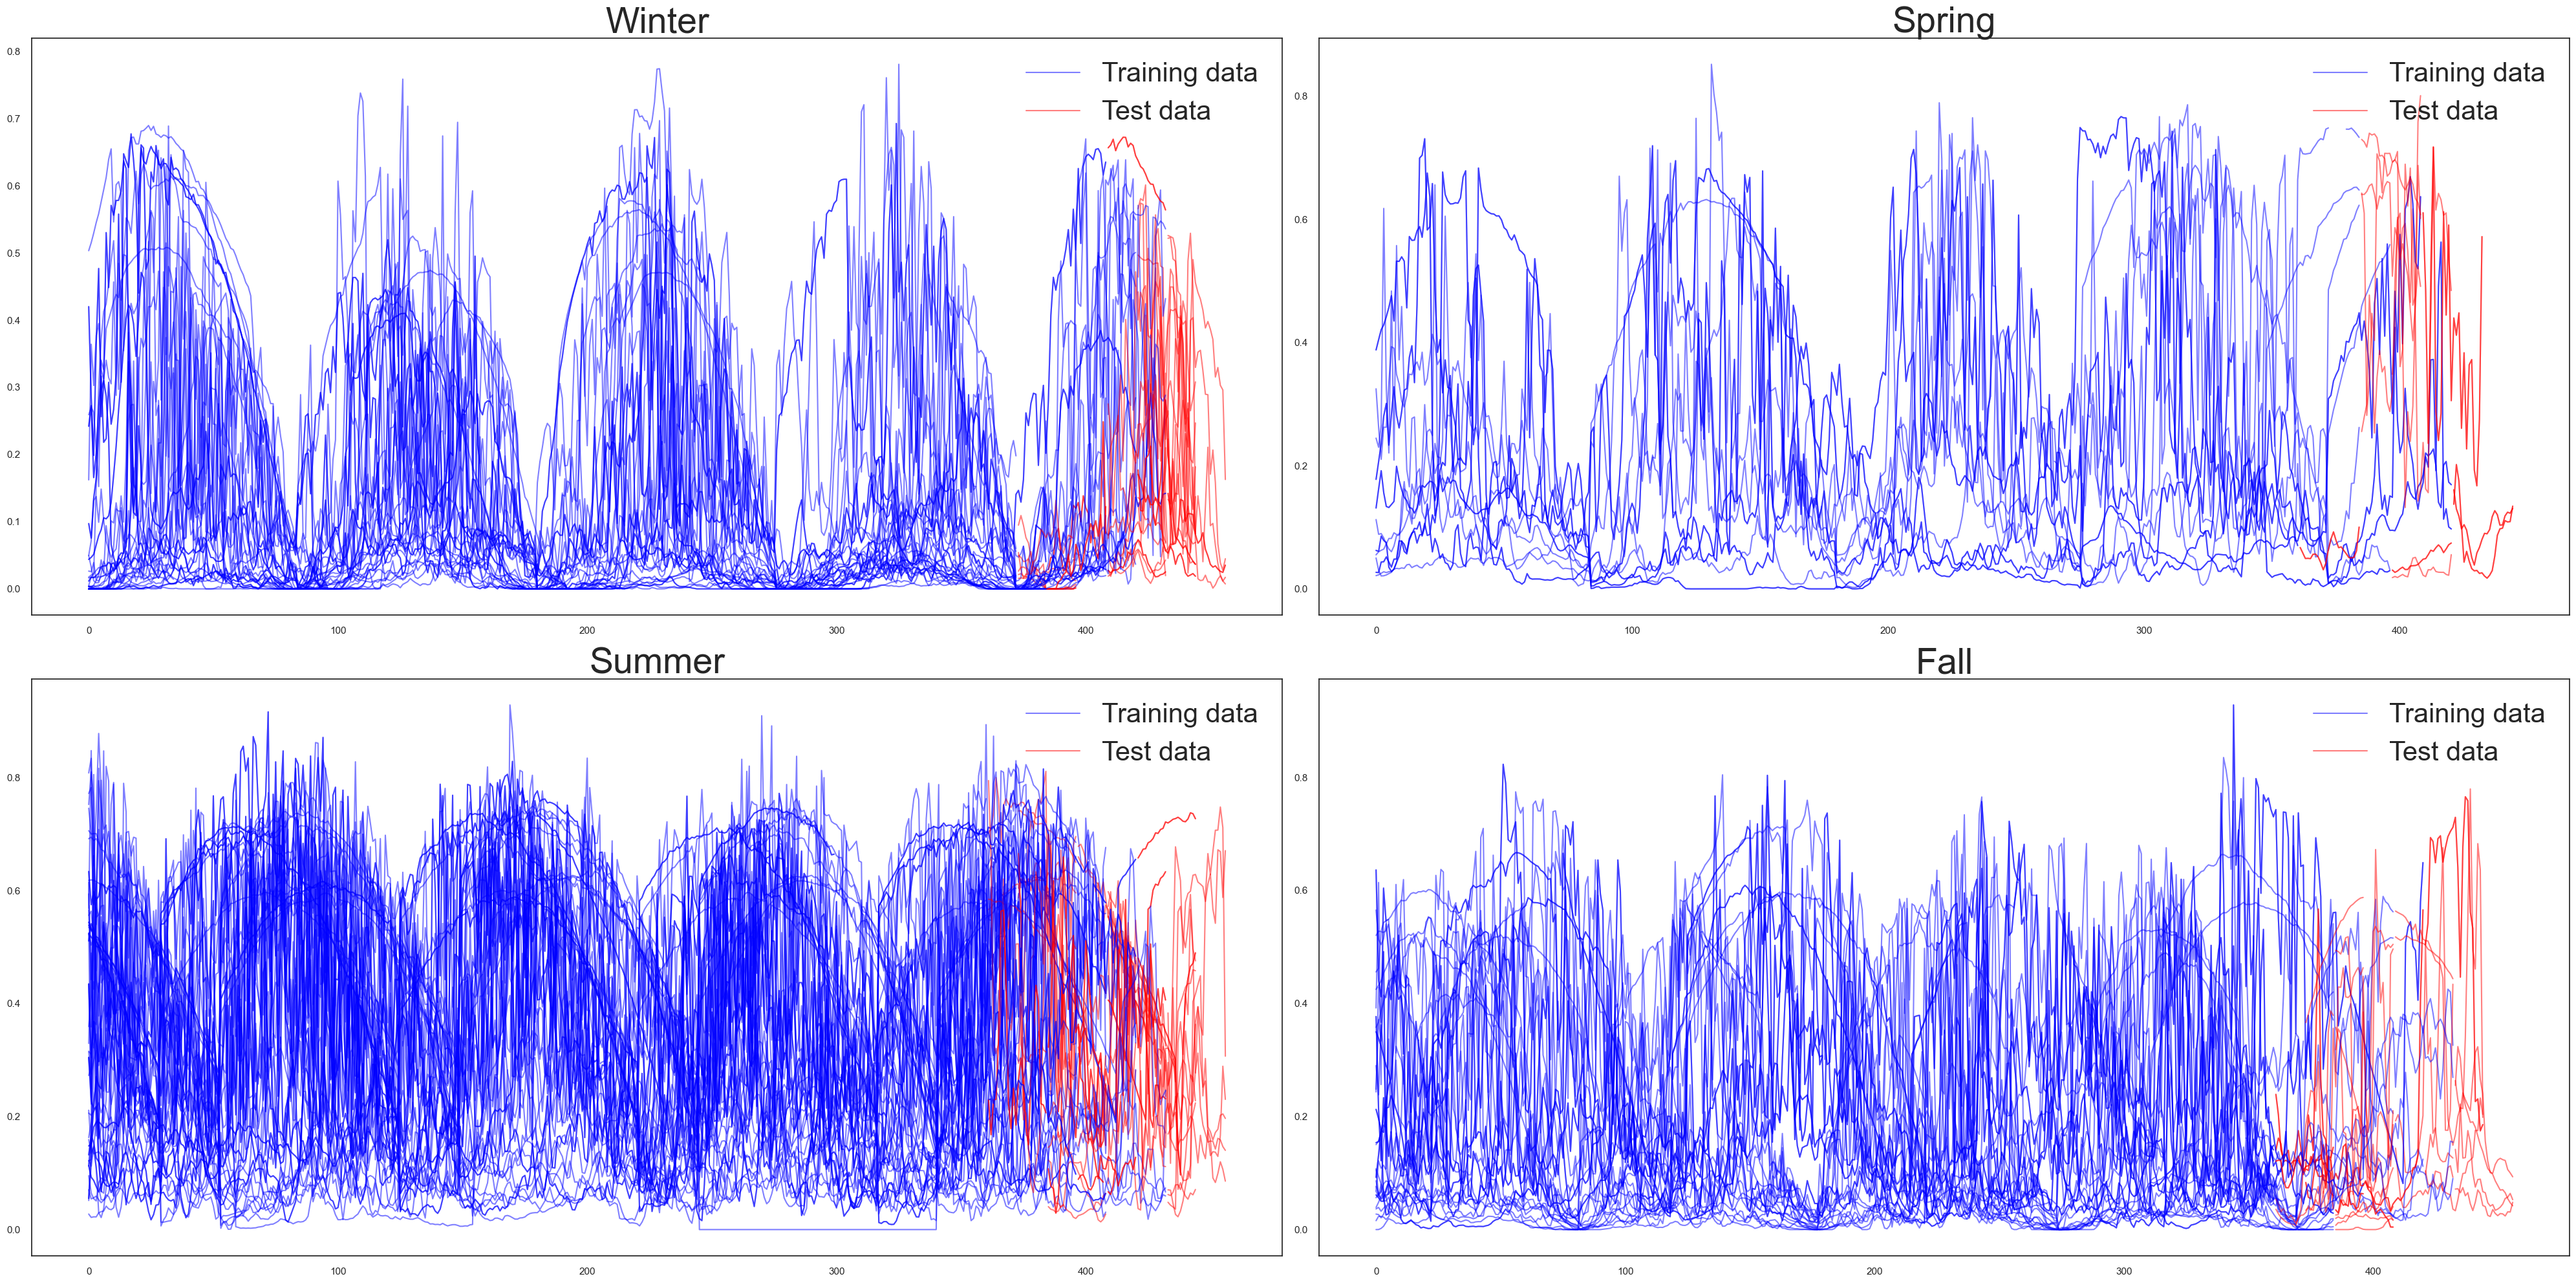

In [8]:
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(2, 2, figsize=(40, 20))


alpha = 0.5
ax = ax.flatten()
labeling = True
for (x_tr, y_tr), (x_te, y_te) in zip(train_loader_w, test_loader_w):

    for i in range(y_tr.shape[1]):
        t_train = torch.arange(y_tr.shape[0])
        t_test = torch.arange(y_tr.shape[0], y_te.shape[0] + y_tr.shape[0])
        if labeling:
            ax[0].plot(t_train, y_tr[:,i], color='blue', alpha=alpha, label='Training data')
            ax[0].plot(t_test, y_te[:,i], color='red', alpha=alpha, label='Test data')
            labeling = False
        else:
            ax[0].plot(t_train, y_tr[:,i], color='blue', alpha=alpha)
            ax[0].plot(t_test, y_te[:,i], color='red', alpha=alpha)

ax[0].legend(loc='upper right', fontsize=30)
ax[0].set_title('Winter', fontsize=40)

labeling = True
for (x_tr, y_tr), (x_te, y_te) in zip(train_loader_sp, test_loader_sp):
    for i in range(y_tr.shape[1]):
        t_train = torch.arange(y_tr.shape[0])
        t_test = torch.arange(y_tr.shape[0], y_te.shape[0] + y_tr.shape[0])
        if labeling:
            ax[1].plot(t_train, y_tr[:,i], color='blue', alpha=alpha, label='Training data')
            ax[1].plot(t_test, y_te[:,i], color='red', alpha=alpha, label='Test data')
            labeling = False
        else:
            ax[1].plot(t_train, y_tr[:,i], color='blue', alpha=alpha)
            ax[1].plot(t_test, y_te[:,i], color='red', alpha=alpha)

ax[1].legend(loc='upper right', fontsize=30)
ax[1].set_title('Spring', fontsize=40)

labeling = True

for (x_tr, y_tr), (x_te, y_te) in zip(train_loader_su, test_loader_su):
    for i in range(y_tr.shape[1]):
        t_train = torch.arange(y_tr.shape[0])
        t_test = torch.arange(y_tr.shape[0], y_te.shape[0] + y_tr.shape[0])
        if labeling:
            ax[2].plot(t_train, y_tr[:,i], color='blue', alpha=alpha, label='Training data')
            ax[2].plot(t_test, y_te[:,i], color='red', alpha=alpha, label='Test data')
            labeling = False
        else:
            ax[2].plot(t_train, y_tr[:,i], color='blue', alpha=alpha)
            ax[2].plot(t_test, y_te[:,i], color='red', alpha=alpha)

ax[2].legend(loc='upper right', fontsize=30)
ax[2].set_title('Summer', fontsize=40)

labeling = True
for (x_tr, y_tr), (x_te, y_te) in zip(train_loader_f, test_loader_f):
    
    for i in range(y_tr.shape[1]):
        t_train = torch.arange(y_tr.shape[0])
        t_test = torch.arange(y_tr.shape[0], y_te.shape[0] + y_tr.shape[0])
        if labeling:
            ax[3].plot(t_train, y_tr[:,i], color='blue', alpha=alpha, label='Training data')
            ax[3].plot(t_test, y_te[:,i], color='red', alpha=alpha, label='Test data')
            labeling = False
        else:
            ax[3].plot(t_train, y_tr[:,i], color='blue', alpha=alpha)
            ax[3].plot(t_test, y_te[:,i], color='red', alpha=alpha)

ax[3].legend(loc='upper right', fontsize=30)
ax[3].set_title('Fall', fontsize=40)

plt.tight_layout()
plt.show()

In [9]:
model_winter = BetaQPGPOneDim(train_loader=train_loader_w, test_loader=test_loader_w)

In [10]:
model_winter.run_study(n_trials=20, direction='minimize')

[I 2023-08-02 12:32:18,594] A new study created in memory with name: no-name-0e041bf5-9dc7-4b31-abd5-d574eeed9b39


Percentiles coverage: 20.83%
NLPD: 0.0872
Percentiles coverage: 37.50%
NLPD: 0.0773
Percentiles coverage: 25.00%
NLPD: 0.1952
Percentiles coverage: 58.33%
NLPD: 0.0223
Percentiles coverage: 37.50%
NLPD: -0.0592
NaN error, skip nr.: 1
Percentiles coverage: 25.00%
NLPD: 0.0232
Percentiles coverage: 25.00%
NLPD: -0.0314
Percentiles coverage: 87.50%
NLPD: -0.0518
Percentiles coverage: 58.33%
NLPD: -0.0425
Percentiles coverage: 8.33%
NLPD: 0.2681
NaN error, skip nr.: 2
Percentiles coverage: 37.50%
NLPD: 0.0432
Percentiles coverage: 62.50%
NLPD: -0.0350
Percentiles coverage: 54.17%
NLPD: 0.0023
Percentiles coverage: 66.67%
NLPD: -0.0102
Percentiles coverage: 79.17%
NLPD: -0.0838
Percentiles coverage: 75.00%
NLPD: -0.0840
Percentiles coverage: 58.33%
NLPD: -0.0434
Percentiles coverage: 62.50%
NLPD: -0.0409
Percentiles coverage: 16.67%
NLPD: 0.0821
Percentiles coverage: 16.67%
NLPD: 0.0956
Percentiles coverage: 16.67%
NLPD: -0.0278
Percentiles coverage: 0.00%
NLPD: 0.0958
Percentiles coverage:

[I 2023-08-02 12:36:00,361] Trial 0 finished with value: -0.006504276301711798 and parameters: {'scale_init': 26, 'mean': 'constant', 'lr * 100': 30, 'epochs': 100}. Best is trial 0 with value: -0.006504276301711798.


Percentiles coverage: 41.67%
NLPD: -0.0494
Percentiles coverage: 16.67%
NLPD: 0.0443
Percentiles coverage: 29.17%
NLPD: 0.0871
Percentiles coverage: 25.00%
NLPD: 0.1769
Percentiles coverage: 70.83%
NLPD: -0.0283
Percentiles coverage: 37.50%
NLPD: -0.0441
NaN error, skip nr.: 1
Percentiles coverage: 29.17%
NLPD: -0.0140
Percentiles coverage: 25.00%
NLPD: -0.0346
Percentiles coverage: 79.17%
NLPD: -0.0581
Percentiles coverage: 66.67%
NLPD: -0.0544
Percentiles coverage: 12.50%
NLPD: 0.2099
NaN error, skip nr.: 2
Percentiles coverage: 75.00%
NLPD: -0.0192
Percentiles coverage: 66.67%
NLPD: -0.0211
Percentiles coverage: 58.33%
NLPD: -0.0008
Percentiles coverage: 58.33%
NLPD: -0.0099
Percentiles coverage: 75.00%
NLPD: -0.0880
Percentiles coverage: 70.83%
NLPD: -0.0812
Percentiles coverage: 33.33%
NLPD: -0.0099
Percentiles coverage: 37.50%
NLPD: -0.0221
Percentiles coverage: 16.67%
NLPD: 0.0917
Percentiles coverage: 16.67%
NLPD: 0.0686
Percentiles coverage: 12.50%
NLPD: -0.0090
Early stopping

[I 2023-08-02 13:06:09,979] Trial 1 finished with value: -0.010343695990741253 and parameters: {'scale_init': 31, 'mean': 'zero', 'lr * 100': 25, 'epochs': 800}. Best is trial 1 with value: -0.010343695990741253.


Percentiles coverage: 50.00%
NLPD: -0.0438
Percentiles coverage: 29.17%
NLPD: 0.0863
Percentiles coverage: 58.33%
NLPD: 0.0148
Percentiles coverage: 37.50%
NLPD: 0.0478
Percentiles coverage: 87.50%
NLPD: -0.0066
Percentiles coverage: 45.83%
NLPD: -0.0832
NaN error, skip nr.: 1
Percentiles coverage: 45.83%
NLPD: -0.0545
Percentiles coverage: 33.33%
NLPD: -0.0512
Percentiles coverage: 100.00%
NLPD: -0.0466
Percentiles coverage: 100.00%
NLPD: -0.0439
Percentiles coverage: 33.33%
NLPD: 0.0565
NaN error, skip nr.: 2
Percentiles coverage: 83.33%
NLPD: -0.0206
Percentiles coverage: 87.50%
NLPD: -0.0323
Percentiles coverage: 95.83%
NLPD: -0.0293
Percentiles coverage: 79.17%
NLPD: -0.0234
Percentiles coverage: 83.33%
NLPD: -0.0742
Percentiles coverage: 87.50%
NLPD: -0.0746
Percentiles coverage: 66.67%
NLPD: -0.0478
Percentiles coverage: 54.17%
NLPD: -0.0290
Percentiles coverage: 25.00%
NLPD: 0.0201
Percentiles coverage: 37.50%
NLPD: 0.0050
Percentiles coverage: 12.50%
NLPD: 0.0012
Percentiles c

[I 2023-08-02 13:18:21,932] Trial 2 finished with value: -0.026482578366994858 and parameters: {'scale_init': 16, 'mean': 'zero', 'lr * 100': 10, 'epochs': 200}. Best is trial 2 with value: -0.026482578366994858.


Percentiles coverage: 79.17%
NLPD: -0.0445
Percentiles coverage: 29.17%
NLPD: 0.0776
Percentiles coverage: 29.17%
NLPD: 0.1032
Percentiles coverage: 25.00%
NLPD: 0.3728
Percentiles coverage: 37.50%
NLPD: 0.0590
Percentiles coverage: 41.67%
NLPD: 0.0192
NaN error, skip nr.: 1
Percentiles coverage: 20.83%
NLPD: 0.1435
Percentiles coverage: 25.00%
NLPD: 0.0512
Percentiles coverage: 58.33%
NLPD: -0.0420
Percentiles coverage: 50.00%
NLPD: -0.0206
Percentiles coverage: 4.17%
NLPD: 0.6223
NaN error, skip nr.: 2
Percentiles coverage: 29.17%
NLPD: 0.1384
Percentiles coverage: 50.00%
NLPD: 0.0875
Percentiles coverage: 29.17%
NLPD: 0.0360
Percentiles coverage: 25.00%
NLPD: 0.0278
Percentiles coverage: 75.00%
NLPD: -0.0832
Percentiles coverage: 66.67%
NLPD: -0.0860
Percentiles coverage: 45.83%
NLPD: -0.0341
Percentiles coverage: 45.83%
NLPD: -0.0280
Percentiles coverage: 4.17%
NLPD: 0.2050
Percentiles coverage: 4.17%
NLPD: 0.1680
Percentiles coverage: 8.33%
NLPD: 0.0360
Percentiles coverage: 0.00%

[I 2023-08-02 13:43:36,680] Trial 3 finished with value: 0.03944721817970276 and parameters: {'scale_init': 11, 'mean': 'constant', 'lr * 100': 20, 'epochs': 300}. Best is trial 2 with value: -0.026482578366994858.


Percentiles coverage: 29.17%
NLPD: -0.0293
Percentiles coverage: 20.83%
NLPD: 0.0592
Percentiles coverage: 45.83%
NLPD: 0.0433
Percentiles coverage: 95.83%
NLPD: -0.0486
Percentiles coverage: 50.00%
NLPD: 0.0098
Percentiles coverage: 37.50%
NLPD: -0.0004
NaN error, skip nr.: 1
Percentiles coverage: 20.83%
NLPD: 0.0703
Percentiles coverage: 20.83%
NLPD: 0.0141
Percentiles coverage: 95.83%
NLPD: -0.0540
Percentiles coverage: 100.00%
NLPD: -0.0524
Percentiles coverage: 16.67%
NLPD: 0.1069
NaN error, skip nr.: 2
Percentiles coverage: 58.33%
NLPD: -0.0072
Percentiles coverage: 70.83%
NLPD: -0.0316
Percentiles coverage: 45.83%
NLPD: 0.0207
Percentiles coverage: 45.83%
NLPD: 0.0121
Percentiles coverage: 66.67%
NLPD: -0.0667
Percentiles coverage: 66.67%
NLPD: -0.0736
Percentiles coverage: 29.17%
NLPD: -0.0042
Percentiles coverage: 16.67%
NLPD: 0.0172
Percentiles coverage: 20.83%
NLPD: 0.0592
Percentiles coverage: 25.00%
NLPD: 0.0404
Percentiles coverage: 4.17%
NLPD: 0.0740
Percentiles coverage

[I 2023-08-02 13:59:55,312] Trial 4 finished with value: -0.0070150867104530334 and parameters: {'scale_init': 41, 'mean': 'zero', 'lr * 100': 15, 'epochs': 400}. Best is trial 2 with value: -0.026482578366994858.


Percentiles coverage: 37.50%
NLPD: -0.0066
Percentiles coverage: 100.00%
NLPD: -0.0085
Percentiles coverage: 87.50%
NLPD: -0.0282
Percentiles coverage: 75.00%
NLPD: 0.0037
Percentiles coverage: 100.00%
NLPD: -0.0269
Percentiles coverage: 54.17%
NLPD: -0.2636
NaN error, skip nr.: 1
Percentiles coverage: 45.83%
NLPD: -0.0759
Percentiles coverage: 58.33%
NLPD: -0.1423
Percentiles coverage: 100.00%
NLPD: -0.0514
Percentiles coverage: 100.00%
NLPD: -0.0541
Percentiles coverage: 50.00%
NLPD: 0.0283
NaN error, skip nr.: 2
Percentiles coverage: 75.00%
NLPD: -0.0192
Percentiles coverage: 70.83%
NLPD: -0.0332
Percentiles coverage: 58.33%
NLPD: -0.0024
Percentiles coverage: 58.33%
NLPD: 0.0021
Percentiles coverage: 70.83%
NLPD: -0.0623
Percentiles coverage: 79.17%
NLPD: -0.0786
Percentiles coverage: 37.50%
NLPD: -0.0179
Percentiles coverage: 29.17%
NLPD: 0.0106
Percentiles coverage: 33.33%
NLPD: 0.0210
Percentiles coverage: 20.83%
NLPD: 0.0597
Percentiles coverage: 4.17%
NLPD: 0.0190
Percentiles 

[I 2023-08-02 14:12:31,989] Trial 5 finished with value: -0.03314897418022156 and parameters: {'scale_init': 6, 'mean': 'zero', 'lr * 100': 10, 'epochs': 300}. Best is trial 5 with value: -0.03314897418022156.


Percentiles coverage: 83.33%
NLPD: -0.0163
Percentiles coverage: 20.83%
NLPD: 0.0598
Percentiles coverage: 62.50%
NLPD: -0.0090
Percentiles coverage: 33.33%
NLPD: 0.0625
Percentiles coverage: 100.00%
NLPD: -0.0303
Percentiles coverage: 50.00%
NLPD: -0.1793
NaN error, skip nr.: 1
Percentiles coverage: 45.83%
NLPD: -0.0929
Percentiles coverage: 58.33%
NLPD: -0.1312
Percentiles coverage: 87.50%
NLPD: -0.0534
Percentiles coverage: 100.00%
NLPD: -0.0578
Percentiles coverage: 12.50%
NLPD: 0.1232
NaN error, skip nr.: 2
Percentiles coverage: 58.33%
NLPD: -0.0028
Percentiles coverage: 58.33%
NLPD: -0.0124
Percentiles coverage: 45.83%
NLPD: 0.0241
Percentiles coverage: 33.33%
NLPD: 0.0476
Percentiles coverage: 70.83%
NLPD: -0.0684
Percentiles coverage: 83.33%
NLPD: -0.0867
Percentiles coverage: 45.83%
NLPD: -0.0226
Percentiles coverage: 62.50%
NLPD: -0.0450
Percentiles coverage: 16.67%
NLPD: 0.0701
Percentiles coverage: 12.50%
NLPD: 0.0797
Percentiles coverage: 41.67%
NLPD: -0.0489
Percentiles c

In [ ]:
# import visualization functions from optuna to visualize the hyperparameter tuning process
from optuna.visualization import (plot_optimization_history,
                                 plot_param_importances,
                                 plot_contour, 
                                 plot_parallel_coordinate)

study = model_winter.study
plot_parallel_coordinate(study)

NameError: name 'model_winter' is not defined

In [ ]:
plot_param_importances(study)